# How to view and update state in subgraphs
> https://langchain-ai.github.io/langgraph/how-tos/subgraphs-manage-state/

In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

### Subgraph

In [4]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"


raw_model = ChatOpenAI(model="gpt-4o-mini")
model = raw_model.with_structured_output(get_weather)


class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state["messages"])
    return {"city": result["city"]}


def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state["city"]})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

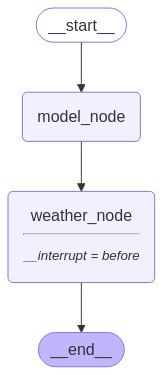

In [5]:
from IPython.display import Image

Image(subgraph.get_graph().draw_mermaid_png())

### Parent graph

In [6]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]


router_model = raw_model.with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state["messages"])
    return {"messages": [response]}


def route_after_prediction(
    state: RouterState,
) -> Literal["weather_graph", "normal_llm_node"]:
    if state["route"] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

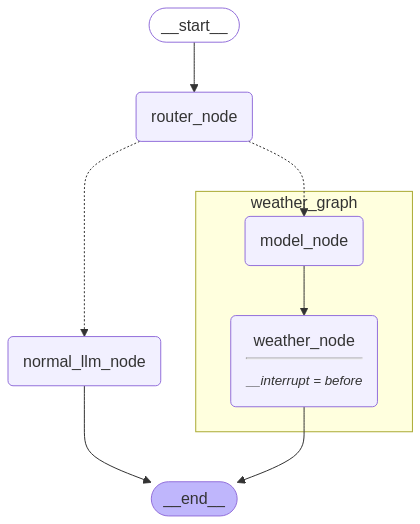

In [10]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-91910094-6d68-46a2-8f42-75efeab5057a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


## Resume from breakpoints

Stream:

In [14]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}
{'__interrupt__': ()}


Stream with subgraphs:

In [15]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')]})
((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'route': 'weather'})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')]})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'city': 'San Francisco'})


State:

In [16]:
state = graph.get_state(config)
state.next

('weather_graph',)

In [17]:
state.tasks

(PregelTask(id='6ad96f80-3396-ff37-4fbb-4e27f0054087', name='weather_graph', path=('__pregel_pull', 'weather_graph'), error=None, interrupts=(), state={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087'}}, result=None),)

State with subgraph

In [18]:
state = graph.get_state(config, subgraphs=True)
state.tasks[0]

PregelTask(id='6ad96f80-3396-ff37-4fbb-4e27f0054087', name='weather_graph', path=('__pregel_pull', 'weather_graph'), error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087', 'checkpoint_id': '1f004a1c-141f-688a-8001-550b03658384', 'checkpoint_map': {'': '1f004a1c-0d3c-614e-8001-710452897805', 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087': '1f004a1c-141f-688a-8001-550b03658384'}}}, metadata={'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087', 'thread_id': '3', 'checkpoint_map': {'': '1f004a1c-0d3c-614e-8001-710452897805'}, 'checkpoint_id': '1f004a1c-0d40-635c-8000-21e8d6ffcada', 'langgraph_step': 2, 'langgraph_node': 'weather_graph', 'langgraph_triggers'

Resume with previous state:

In [19]:
for update in graph.stream(None, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'route': 'weather'})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'city': 'San Francisco'})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1'), AIMessage(content="It's sunny in San Francisco!", additional_kwargs={}, response_metadata={}, id='22031e8a-e08d-4bb8-b39d-a9bf40523568')], 'city': 'San Francisco'})
((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1'), AIMessage(content="It's sunny in San Francisco!", additi

## Resume from specific subgraph node

Filter state history of subgraph:

In [24]:
parent_graph_state_before_subgraph = next(
    h for h in graph.get_state_history(config) if h.next == ("weather_graph",)
)

parent_graph_state_before_subgraph.tasks[0].state

{'configurable': {'thread_id': '3',
  'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087'}}

In [25]:
subgraph_state_before_model_node = next(
    h
    for h in graph.get_state_history(parent_graph_state_before_subgraph.tasks[0].state)
    if h.next == ("model_node",)
)

In [26]:
subgraph_state_before_model_node

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')]}, next=('model_node',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087', 'checkpoint_id': '1f004a1c-0d40-635c-8000-21e8d6ffcada', 'checkpoint_map': {'': '1f004a1c-0d3c-614e-8001-710452897805', 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087': '1f004a1c-0d40-635c-8000-21e8d6ffcada'}}}, metadata={'checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087', 'thread_id': '3', 'checkpoint_map': {'': '1f004a1c-0d3c-614e-8001-710452897805'}, 'checkpoint_id': '1f004a1c-0d3e-6bd8-bfff-b177a01bd135', 'langgraph_step': 2, 'langgraph_node': 'weather_graph', 'langgraph_triggers': ['branch:router_node:route_after_prediction:weather_graph'], 'langgraph_path': ['__pregel_pull', 'weather_graph'], 'langgraph_checkpoint_ns': 'weather_graph:6ad96f80-3396-ff37

In [27]:
subgraph_state_before_model_node.next

('model_node',)

Resume from the `model_node` inside the subgraph:

In [28]:
for value in graph.stream(
    None,
    config=subgraph_state_before_model_node.config,
    stream_mode="values",
    subgraphs=True,
):
    print(value)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'route': 'weather'})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')]})
(('weather_graph:6ad96f80-3396-ff37-4fbb-4e27f0054087',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c0a76791-2098-411c-a528-58651f4c6ef1')], 'city': 'San Francisco'})


## Modifying state

### Update the state of a subgraph

In [29]:
config = {"configurable": {"thread_id": "4"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}
{'__interrupt__': ()}


In [32]:
state = graph.get_state(config, subgraphs=True)
state.values["messages"]

[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c9b7f45e-4452-4947-a73a-edd07e797c07')]

Get config of state of subgraph:

In [36]:
subgraph_state_config = state.tasks[0].state.config
subgraph_state_config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': 'weather_graph:eb29847f-e44d-ef65-f46a-6553b56b5a99',
  'checkpoint_id': '1f004a53-d2d1-6a58-8001-e0e0ed5c273e',
  'checkpoint_map': {'': '1f004a53-cd81-6170-8001-18030d6a3446',
   'weather_graph:eb29847f-e44d-ef65-f46a-6553b56b5a99': '1f004a53-d2d1-6a58-8001-e0e0ed5c273e'}}}

In [37]:
graph.update_state(subgraph_state_config, {"city": "la"})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': 'weather_graph:eb29847f-e44d-ef65-f46a-6553b56b5a99',
  'checkpoint_id': '1f004a59-6ee8-628e-8002-3aa8b52400e6',
  'checkpoint_map': {'': '1f004a53-cd81-6170-8001-18030d6a3446',
   'weather_graph:eb29847f-e44d-ef65-f46a-6553b56b5a99': '1f004a59-6ee8-628e-8002-3aa8b52400e6'}}}

Resume:

In [38]:
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

(('weather_graph:eb29847f-e44d-ef65-f46a-6553b56b5a99',), {'weather_node': {'messages': [{'role': 'assistant', 'content': "It's sunny in la!"}]}})
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='c9b7f45e-4452-4947-a73a-edd07e797c07'), AIMessage(content="It's sunny in la!", additional_kwargs={}, response_metadata={}, id='84bced9c-0685-4785-ae65-8f6d2f86cefd')]}})


### Acting as a subgraph node

In [39]:
config = {"configurable": {"thread_id": "14"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")

state = graph.get_state(config, subgraphs=True)

# We update the state by passing in the message we want returned from the weather node, and make sure to use as_node
graph.update_state(
    state.tasks[0].state.config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_node",
)
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

print(graph.get_state(config).values["messages"])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:7b6b2f6a-501b-b35c-906c-acb14cb50fd8',), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})
interrupted!
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='4bec4b0a-48c2-4d26-86a8-28eed0513a6d'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='83294910-9fe5-4b5b-a26d-458f325c5796')]}})
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='4bec4b0a-48c2-4d26-86a8-28eed0513a6d'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='83294910-9fe5-4b5b-a26d-458f325c5796')]


### Acting as the entire subgraph

In [40]:
config = {"configurable": {"thread_id": "8"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")

# We update the state by passing in the message we want returned from the weather graph, making sure to use as_node
# Note that we don't need to pass in the subgraph config, since we aren't updating the state inside the subgraph
graph.update_state(
    config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_graph",
)
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

print(graph.get_state(config).values["messages"])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:a04c73a0-2ab8-40e5-c9bc-23b8673de89a',), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})
interrupted!
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f8a2ed3d-1e7c-4dc6-99b1-58cb0929d082'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='eb3bf565-5cdd-4468-b841-a73ddf926389')]


## Double nested subgraphs

In [41]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]


router_model = raw_model.with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state["messages"])
    return {"messages": [response]}


def route_after_prediction(
    state: RouterState,
) -> Literal["weather_graph", "normal_llm_node"]:
    if state["route"] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile()

In [42]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class GrandfatherState(MessagesState):
    to_continue: bool


def router_node(state: GrandfatherState):
    # Dummy logic that will always continue
    return {"to_continue": True}


def route_after_prediction(state: GrandfatherState):
    if state["to_continue"]:
        return "graph"
    else:
        return END


grandparent_graph = StateGraph(GrandfatherState)
grandparent_graph.add_node(router_node)
grandparent_graph.add_node("graph", graph)
grandparent_graph.add_edge(START, "router_node")
grandparent_graph.add_conditional_edges(
    "router_node", route_after_prediction, ["graph", END]
)
grandparent_graph.add_edge("graph", END)
grandparent_graph = grandparent_graph.compile(checkpointer=MemorySaver())

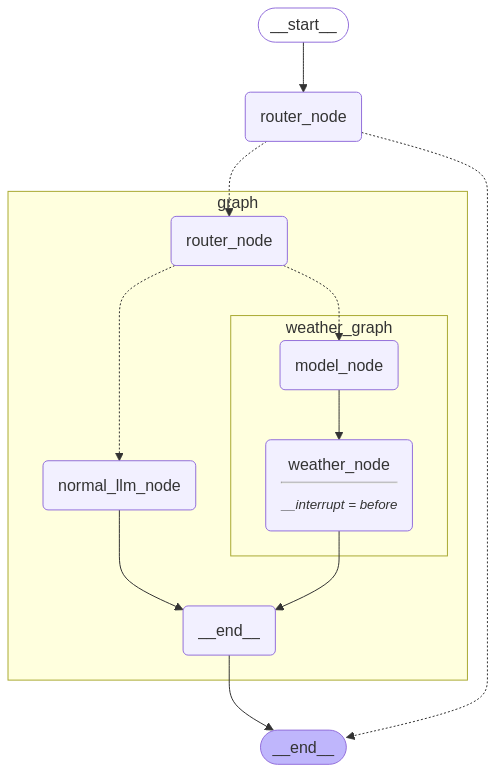

In [43]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(grandparent_graph.get_graph(xray=2).draw_mermaid_png()))

In [44]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in grandparent_graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)

((), {'router_node': {'to_continue': True}})
(('graph:be845be9-6117-27f5-4f94-ec50018f18b4',), {'router_node': {'route': 'weather'}})
(('graph:be845be9-6117-27f5-4f94-ec50018f18b4', 'weather_graph:689096cf-c90f-877b-dc27-dd67ad9335c8'), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})


In [45]:
state = grandparent_graph.get_state(config, subgraphs=True)
print("Grandparent State:")
print(state.values)
print("---------------")
print("Parent Graph State:")
print(state.tasks[0].state.values)
print("---------------")
print("Subgraph State:")
print(state.tasks[0].state.tasks[0].state.values)

Grandparent State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a')], 'to_continue': True}
---------------
Parent Graph State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a')], 'route': 'weather'}
---------------
Subgraph State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a')], 'city': 'San Francisco'}


In [46]:
grandparent_graph_state = state
parent_graph_state = grandparent_graph_state.tasks[0].state
subgraph_state = parent_graph_state.tasks[0].state
grandparent_graph.update_state(
    subgraph_state.config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_node",
)
for update in grandparent_graph.stream(
    None, config=config, stream_mode="updates", subgraphs=True
):
    print(update)

print(grandparent_graph.get_state(config).values["messages"])

(('graph:be845be9-6117-27f5-4f94-ec50018f18b4',), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='e31cbecc-d9d9-46f2-9a44-db3434150663')]}})
((), {'graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='e31cbecc-d9d9-46f2-9a44-db3434150663')]}})
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='e31cbecc-d9d9-46f2-9a44-db3434150663')]


In [47]:
for state in grandparent_graph.get_state_history(config):
    print(state)
    print("-----")

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='e31cbecc-d9d9-46f2-9a44-db3434150663')], 'to_continue': True}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f004a73-d528-63fe-8002-5fd9da3e9d10'}}, metadata={'checkpoint_ns': '', 'thread_id': '2', 'checkpoint_id': '1f004a71-2fe9-648a-8001-a64fdf4f73f2', 'source': 'loop', 'writes': {'graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='3cde3cac-aa1d-48f6-8cac-874e5662618a'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='e31cbecc-d9d9-46f2-9a44-db3434150663')]}}, 'step': 2, 'parents': {}}, created_at='2025-03-19T09:47:58.335266+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 